In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)

import KSEMhd
from importlib import reload  
KSEMhd = reload(KSEMhd)
from KSEMhd import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_brooklyn"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
# den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)
den_simu = AerSimulator(method='density_matrix')

n_qubits = 3
reps = 8
max_num_itrs = 10

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067522 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067576 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067189 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9704, 0.0296], [0.04200000000000004, 0.958]],
 'gate_qubits': [(64,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-05-26 00:28:00-04:00


In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.ccx(0,1,2)
    iterate.barrier()
    return iterate
# def single_iter(n_qubits=2):
#     iterate = QuantumCircuit(n_qubits)
#     iterate.h(0)
#     iterate.cx(0,1)
#     iterate.cx(1,2)
#     iterate.barrier()
#     iterate.cx(1,2)
#     iterate.cx(0,1)
#     iterate.h(0)
#     iterate.barrier()
#     return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True, meas_basis='z'):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if meas_basis == 'x':
        for i in range(n_qubits):
            total_circ.h(i)
    if meas_basis == 'y':
        for i in range(n_qubits):
            total_circ.sdg(i)
            total_circ.h(i)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

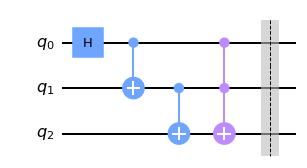

In [8]:
single_iter(n_qubits).draw("mpl")

4


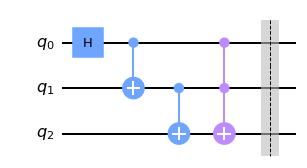

In [9]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [10]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 248
T1: 9.275249258271653e-05 sec
T2: 9.733613343913872e-05 sec
Circuit Operation Time: 6.068266666666667e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [11]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [12]:
total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEMhd.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
1.0000000000000004
1.0000000000000009
1.0000000000000013
1.0000000000000018
1.0000000000000022
1.0000000000000027
1.000000000000003
1.0000000000000036
1.0000000000000044
1.0000000000000049

Prob Vec
[0.50039673 0.         0.         0.49960327 0.         0.
 0.         0.        ]
[0.25177002 0.25119019 0.         0.25042725 0.         0.
 0.24661255 0.        ]
[0.         0.12614441 0.12550354 0.49647522 0.         0.12530518
 0.12657166 0.        ]
[0.06138611 0.06150818 0.06155396 0.06498718 0.06298828 0.06324768
 0.56219482 0.06213379]
[0.12780762 0.         0.12562561 0.         0.12260437 0.49945068
 0.12451172 0.        ]
[0.06356812 0.06059265 0.06228638 0.06263733 0.56344604 0.06089783
 0.06443787 0.06213379]
[0.         0.12539673 0.         0.12467957 0.50114441 0.12263489
 0.         0.12614441]
[0.06161499 0.06112671 0.06195068 0.06329346 0.56704712 0.06187439
 0.06210327 0.06098938]
[0.1239624  0.12471008 0.         0.         0.12516785 0.12519836
 0.         0.5

In [13]:
def meas_mat(num_qubits):# H, measurement matrix for vectorized density matrix
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = csc_matrix((nrows, ncols), dtype=complex)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1 # take out the diagonal terms in vectorized density matrix
    return mat

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [14]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067522 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067576 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067189 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum al

In [15]:
tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.474580567500694
0.241251678644698
0.31634909696321145
0.34453639277705406
0.31688702358151966
0.344571042943884
0.3121784393007379
0.3317665406215339
0.3161850723352185
0.24314848527942878

Tomography Prob Vec
[0.48617096 0.00831997 0.01195086 0.48465999 0.00317316 0.00142789
 0.00092029 0.00337689]
[0.24620343 0.24860675 0.00974164 0.24083983 0.00558193 0.00319523
 0.24034257 0.00548862]
[0.00796382 0.11631217 0.10640702 0.50517269 0.00335565 0.12779909
 0.12493046 0.00805912]
[0.05536567 0.06296115 0.07207574 0.0637207  0.06778971 0.06008572
 0.55910916 0.05889214]
[0.11769106 0.00335794 0.12177855 0.00497394 0.11626806 0.50570317
 0.12731928 0.002908  ]
[0.07362196 0.06385634 0.05826823 0.06184896 0.55891927 0.0563151
 0.06212023 0.06504991]
[0.00351034 0.12357274 0.0021253  0.12180011 0.49753641 0.11784394
 0.00366851 0.12994266]
[0.06551107 0.06231011 0.05775282 0.06692166 0.54619683 0.06871202
 0.07131619 0.0612793 ]
[0.11879931 0.12169865 0.00139131 0.0058643

## Kalman Smoother

In [16]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

## Add X,Y-basis measurements

In [17]:
total_simu_probs_x = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_basis = 'x'), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs_x.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [18]:
total_simu_probs_y = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_basis = 'y'), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs_y.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [19]:
observs = []
for i in range(len(total_simu_probs)):
    z_meas_p = total_simu_probs[i]
    x_meas_p = total_simu_probs_x[i]
#     y_meas_p = total_simu_probs_y[i]
#     observs.append(np.append(np.append(z_meas_p, x_meas_p),y_meas_p))
    observs.append(np.append(z_meas_p, x_meas_p))
observs

[array([0.50039673, 0.        , 0.        , 0.49960327, 0.        ,
        0.        , 0.        , 0.        , 0.24891663, 0.        ,
        0.        , 0.2514801 , 0.24957275, 0.        , 0.        ,
        0.25003052]),
 array([0.25177002, 0.25119019, 0.        , 0.25042725, 0.        ,
        0.        , 0.24661255, 0.        , 0.12605286, 0.12571716,
        0.12675476, 0.12443542, 0.        , 0.        , 0.        ,
        0.49703979]),
 array([0.        , 0.12614441, 0.12550354, 0.49647522, 0.        ,
        0.12530518, 0.12657166, 0.        , 0.25164795, 0.        ,
        0.24671936, 0.        , 0.        , 0.        , 0.24975586,
        0.25187683]),
 array([0.06138611, 0.06150818, 0.06155396, 0.06498718, 0.06298828,
        0.06324768, 0.56219482, 0.06213379, 0.12289429, 0.12654114,
        0.12623596, 0.12437439, 0.12425232, 0.12654114, 0.12431335,
        0.12484741]),
 array([0.12780762, 0.        , 0.12562561, 0.        , 0.12260437,
        0.49945068, 0.124511

### Initialize

In [20]:
initial_state = np.array([0]*((2**3)**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [21]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = observs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.02 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs, dtype=complex)* 0.1 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.05 * (1)# 
# M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
# Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
# R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
# P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 

In [22]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 16, 4096)

### EM and Smoother - Total

Use longest iterations

In [23]:
def norm_diag(mat):
    her_mat = mat.copy()
    diags = her_mat.diagonal()
    diagsum = diags.sum()
    diags_normed = diags/diagsum
    try: 
        np.fill_diagonal(her_mat, diags_normed)
    except:
        her_mat.setdiag(diags_normed)
    return her_mat

In [24]:
total_smoother_dens = []
total_smoother_purs = []

# observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
# realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
# realX0 = KSEMhd.closed_den_mat(realX0) # find closest valid density matrix
# realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEMhd.closed_den_mat(x_est)
#     final_den = norm_diag(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
C:\ProgramData\Anaconda3\envs\quantum\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll -6246.28, Last ll -6256.28
Iteration     1, New log-likelihood -5.41890e+03, Last log-likelihood -6.24628e+03, Change 8.27388e+02
Iteration     2, New log-likelihood 1.79839e+04, Last log-likelihood -5.41890e+03, Change 2.34027e+04


In [25]:
np.linalg.norm(unitaries[0]-realF)

0.0

In [ ]:
print(np.sum(realQ.real<0))

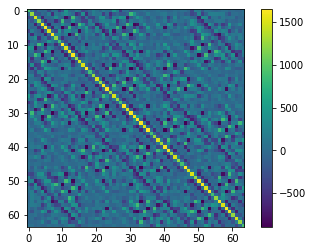

In [26]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

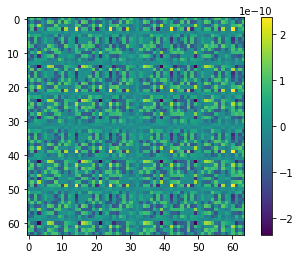

In [27]:
plt.imshow(realQ.imag)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [28]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [29]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [30]:
total_smoother_dens[0].diagonal().flatten()

matrix([[0.4804619 -1.07567493e-28j, 0.19843906+1.65071307e-28j,
         0.01025475+2.01801084e-29j, 0.04727815+1.47114955e-27j,
         0.17512185-3.91147235e-27j, 0.04469664-4.83763080e-28j,
         0.03336791+0.00000000e+00j, 0.01037972+0.00000000e+00j]])

In [31]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[0.4804619 -1.07567493e-28j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.19843906+1.65071307e-28j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.01025475+2.01801084e-29j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.04727815+1.47114955e-27j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0

In [32]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

0.7960965901755066
0.8508173365746767
0.8079655948915887
0.8543520241522808
0.8189499207831101
0.8486324860127253
0.818142892850082
0.8187204050590122
0.8086388272703982
0.8930410711576571


In [33]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.940218476077907
0.9449606905021111
0.8985589804071599
0.8953293083483186
0.9262218762146819
0.9526816128575477
0.9031334850767967
0.859457660810452
0.9119344496457782
0.9470851926820634


## Check the fidelity between estimated state and the real state in the simulator

In [34]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.40688393319994415 Tomo Fid: 0.47636951188801685
Iteration 2 KS Fid: 0.12242154574796373 Tomo Fid: 0.24536764201837935
Iteration 3 KS Fid: 0.18380197567191223 Tomo Fid: 0.30367983409647226
Iteration 4 KS Fid: 0.16198350120569432 Tomo Fid: 0.34425184890473226
Iteration 5 KS Fid: 0.023657907922199444 Tomo Fid: 0.3207924974617477
Iteration 6 KS Fid: 0.005304251364714081 Tomo Fid: 0.3413086004576124
Iteration 7 KS Fid: 0.31154284401124843 Tomo Fid: 0.3110218149571065
Iteration 8 KS Fid: 0.17718053870503545 Tomo Fid: 0.34033204029686354
Iteration 9 KS Fid: 0.0456502101211336 Tomo Fid: 0.3165002298966158
Iteration 10 KS Fid: 0.5688077699774751 Tomo Fid: 0.24879429392984054


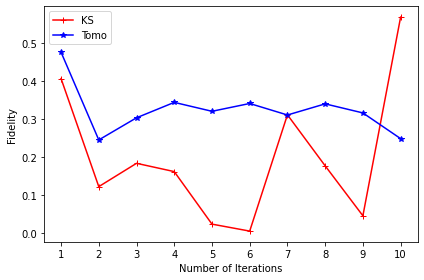

In [35]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.40688394075722584 Tomo Fid: 0.47636951355973917
Iteration 2 KS Fid: 0.12242154690469399 Tomo Fid: 0.2453676423814482
Iteration 3 KS Fid: 0.18380197717840682 Tomo Fid: 0.30367984190324293
Iteration 4 KS Fid: 0.16198350355129462 Tomo Fid: 0.3442518505003442
Iteration 5 KS Fid: 0.02365790902063482 Tomo Fid: 0.3207925016634691
Iteration 6 KS Fid: 0.005304262242887007 Tomo Fid: 0.3413087379867845
Iteration 7 KS Fid: 0.31154284925015485 Tomo Fid: 0.3110218140443509
Iteration 8 KS Fid: 0.17718054263403543 Tomo Fid: 0.34033205050835863
Iteration 9 KS Fid: 0.04565021088742061 Tomo Fid: 0.31650022255770954
Iteration 10 KS Fid: 0.5688077753777349 Tomo Fid: 0.24879429400013084


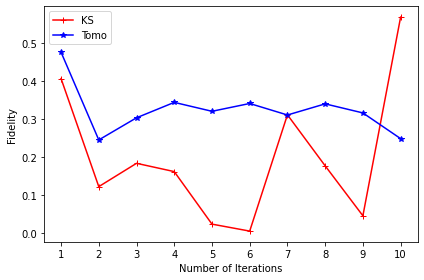

In [36]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 1.0613437758563504 Tomo Norm: 0.722386013577136
Iteration 2 KS Norm: 1.303885577686665 Tomo Norm: 0.866323496649682
Iteration 3 KS Norm: 1.237317675079176 Tomo Norm: 0.8420151000844744
Iteration 4 KS Norm: 1.253539910281508 Tomo Norm: 0.8099584579106169
Iteration 5 KS Norm: 1.3707319435508891 Tomo Norm: 0.8217676314733847
Iteration 6 KS Norm: 1.393582832509976 Tomo Norm: 0.8136054666998531
Iteration 7 KS Norm: 1.1313919750361836 Tomo Norm: 0.8307435409372517
Iteration 8 KS Norm: 1.2268237796848507 Tomo Norm: 0.8069092130602651
Iteration 9 KS Norm: 1.3493087237798067 Tomo Norm: 0.826549839871794
Iteration 10 KS Norm: 0.89970531683993 Tomo Norm: 0.8634581132461537


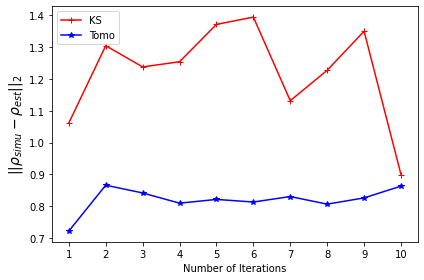

In [37]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

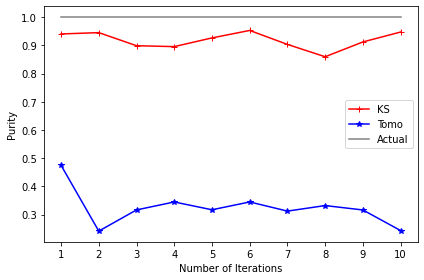

In [38]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

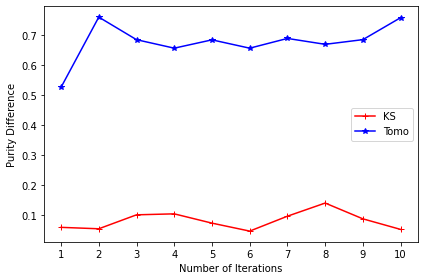

In [39]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()